<a href="https://colab.research.google.com/github/sumanmichael/multi-object-tracking/blob/main/MOT_Ped_Tracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
 
!cp "/gdrive/My Drive/MOT20-05.zip" "/content/"
!unzip MOT20-05.zip
!rm -rf MOT20-05.zip
!mv "gdrive/My Drive/MOT20-05" "MOT20-05/"
!rm -rf gdrive/

In [ ]:
%cd MOT20-05
!cat gt/gt.txt | head -n 2
!cat seqinfo.ini

/content/MOT20-05
1031,1,1,140,5,149,1,1,0.68667
1032,1,1,139,7,149,1,1,0.68667
[Sequence]
name=MOT20-05
imDir=img1
frameRate=25
seqLength=3315
imWidth=1654
imHeight=1080
imExt=.jpg



In [ ]:
!pip install motmetrics line_profiler
%load_ext line_profiler

In [ ]:
img_size = (1654,1080)

In [ ]:
# %%capture cap_out
%%file bbox_trackers.py
import cv2
import pandas as pd
import numpy as np
import progressbar
import sys
import csv
import datetime

tracker_mode = {
    # 'BOOSTING': cv2.TrackerBoosting_create,
    # 'MIL'     : cv2.TrackerMIL_create,
    # 'KCF'     : cv2.TrackerKCF_create,
    # 'TLD'     : cv2.TrackerTLD_create,
    # 'MEDIANFLOW': cv2.TrackerMedianFlow_create,
    # 'GOTURN'  : cv2.TrackerGOTURN_create,
    # 'MOSSE'   : cv2.TrackerMOSSE_create,
    'CSRT'    : cv2.TrackerCSRT_create,
}
tracker_modes = list(tracker_mode.keys())
def track_fun(tracker_modes=tracker_modes):
  gt_columns = ["frame", "id", "bb_left", "bb_top", "bb_width", "bb_height", "conf", "x", "y", "z"]
  gt = pd.read_csv("gt/gt.txt",names=gt_columns)
  gt.drop(["conf","x","y","z"],axis=1,inplace=True)
 
  for TRACKER_MODE in tracker_modes:
    # tracker_df = pd.DataFrame(columns=["frame","id","bb_left","bb_top","bb_width","bb_height"])
    tracker_output_np = np.array([],dtype=np.int32).reshape(-1,6)

    for ped_id in progressbar.progressbar(gt.id.unique()):
      tracker = tracker_mode[TRACKER_MODE]()
 
      gt_ped = gt[gt.id==ped_id].sort_values(by="frame")
      frame_number = gt_ped.frame.iloc[0]
      bbox = tuple(gt_ped[["bb_left","bb_top","bb_width","bb_height"]].iloc[0].values)
 
      img = cv2.imread("img1/{}.jpg".format(str(frame_number).zfill(6)))
      ok = tracker.init(img,bbox)
 
      for i,frame_number in enumerate(gt_ped.frame.iloc[1:]):
        img = cv2.imread("img1/{}.jpg".format(str(frame_number).zfill(6)))
        ok, bbox = tracker.update(img)
        
        if ok:
          # tracker_df.loc[len(tracker_df)]=[int(x) for x in [frame_number,ped_id,*bbox]]
          tracker_output_np = np.concatenate((tracker_output_np,[[ int(x) for x in [frame_number,ped_id,*bbox]]]),axis=0)
        else:
          print(f"{TRACKER_MODE} Tracking Failed for PED:{ped_id} at FRAME:{frame_number} i.e., {i}th appearance",file=sys.stderr)
          break
    
    with open(f"tracker_{TRACKER_MODE}.csv", mode="w") as csvfile:
      writer = csv.writer(csvfile,delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
      writer.writerow(["frame","id","bb_left","bb_top","bb_width","bb_height"])
      writer.writerows(tracker_output_np)
    
    # %%time
    print(f"MODEL:{TRACKER_MODE} completed at {datetime.datetime.now()}")
    

Writing bbox_trackers_A.py


In [ ]:
from bbox_trackers_A import track_fun

%lprun -T boosting_prof -f track_fun track_fun()

In [ ]:
!cp tracker_CSRT.csv "/gdrive/My Drive/outputmot"

cp: cannot stat 'tracker_CSRT.csv': No such file or directory


In [ ]:
# open("tracking_failures.txt","w").write(cap_out.stderr).close()
# open("time_profiles.txt","w").write(cap_out.stdout).close()

In [ ]:
# !cp *.csv "/gdrive/My Drive/outputmot"
# !cp *.txt "/gdrive/My Drive/outputmot"

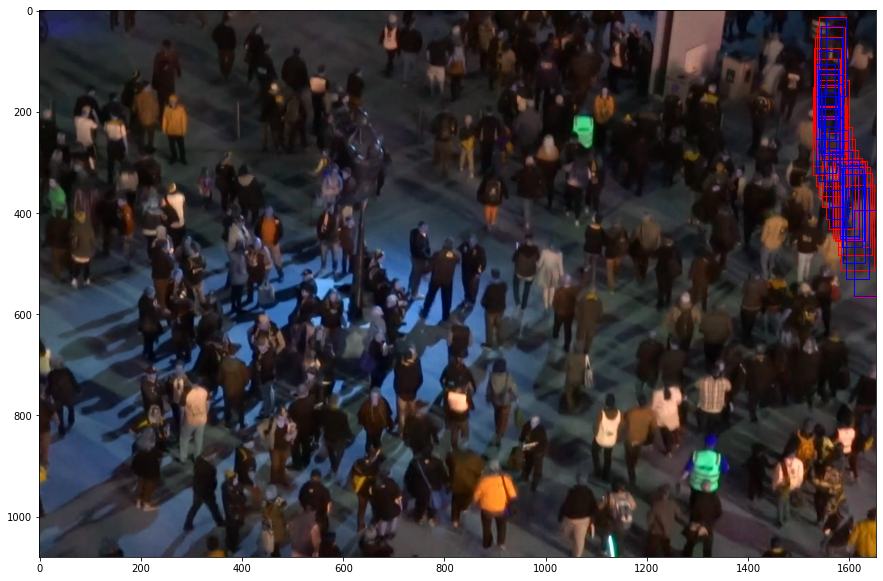

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2

def get_datasets(gt_path="gt/gt.txt",tk_path="tracker_CSRT.csv"):
  gt_columns = ["frame", "id", "bb_left", "bb_top", "bb_width", "bb_height", "conf", "x", "y", "z"]
  gt_csv_df = pd.read_csv(gt_path,names=gt_columns) 
  gt_csv_df.drop(["conf","x","y","z"],axis=1,inplace=True)

  tracker_csv_df = pd.read_csv(tk_path)
  return gt_csv_df[:50000],tracker_csv_df

def plot_ped_track(gt_csv_df,tracker_csv_df,PED_ID,type="dot"):
  
  fig,ax = plt.subplots(1,figsize=(15,15))
  ax.imshow(cv2.imread("img1/{}.jpg".format(str(1).zfill(6))),cmap="gray")
  data_gt = gt_csv_df[gt_csv_df.id==PED_ID].values[:,2:]
  data_tk = tracker_csv_df[tracker_csv_df.id==PED_ID].values[:,2:]

  if type=="dot":
    ax.scatter(*data_gt,color="red")
    ax.scatter(*data_tk,color="blue")
  else:
    for x,y,w,h in data_gt:
      ax.add_patch(
          patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='r',facecolor='none')
      )

    for x,y,w,h in data_tk:
      ax.add_patch(         
          patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='b',facecolor='none')
      )

def plot_frame(gt_csv_df,tracker_csv_df,FRAME_NUM,type="dot"):
  fig,ax = plt.subplots(1,figsize=(15,15))
  ax.imshow(cv2.imread("img1/{}.jpg".format(str(FRAME_NUM).zfill(6))),cmap="gray")

  data_gt = gt_csv_df[gt_csv_df.frame==FRAME_NUM].values[:,2:]
  data_tk = tracker_csv_df[tracker_csv_df.frame==FRAME_NUM].values[:,2:]
  if type=="dot":
    ax.scatter(*data_gt,color="red")
    ax.scatter(*data_tk,color="blue")
  else:
    for x,y,w,h in data_gt:
      ax.add_patch(
          patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='r',facecolor='none')
      )

    for x,y,w,h in data_tk:
      ax.add_patch(
          patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='b',facecolor='none')
      )

# plot_frame(*get_datasets(),201,type="box")
plot_ped_track(*get_datasets(),40,type="box")


In [ ]:
import motmetrics as mm
import progressbar
import numpy as np
import pandas as pd

def get_datasets(gt_path="gt/gt.txt",tk_path="tracker_CSRT.csv"):
  gt_columns = ["frame", "id", "bb_left", "bb_top", "bb_width", "bb_height", "conf", "x", "y", "z"]
  gt_csv_df = pd.read_csv(gt_path,names=gt_columns) 
  gt_csv_df.drop(["conf","x","y","z"],axis=1,inplace=True)

  tracker_csv_df = pd.read_csv(tk_path)
  return gt_csv_df[:50000],tracker_csv_df

def get_mm(gt_csv_df,tracker_csv_df,type="dot",THRESH=200):

  METRIC_COLUMNS = ['num_frames', 'mota', 'motp']

  traj_gt = gt_csv_df.values
  traj_model = tracker_csv_df.values

  frames = np.unique(traj_gt[:,0])

  # Create an accumulator that will be updated during each frame
  acc = mm.MOTAccumulator(auto_id=True)

  for frame in progressbar.progressbar(frames):
      gt = traj_gt[traj_gt[:,0]==frame]
      gt_id = gt[:, 1]
      gt_coords = gt[:, 2:]

      model = traj_model[traj_model[:,0]==frame]
      model_id = model[:, 1]
      model_coords = model[:, 2:]

      if(type=="dot"):
        C = mm.distances.norm2squared_matrix(gt_coords, model_coords, max_d2=THRESH)
      else:
        C = mm.distances.iou_matrix(gt_coords, model_coords, max_iou=THRESH)

      f_id = acc.update(
          gt_id,      # Ground truth objects in this frame
          model_id,   # Detector hypotheses in this frame
          C
      )

  mh = mm.metrics.create()
  summary = mh.compute(acc, metrics=metric_columns, name="LK")
  print(summary)

get_mm(*get_datasets(),type="box",THRESH=0.5)

100% (1221 of 1221) |####################| Elapsed Time: 0:00:02 Time:  0:00:02


    num_frames     mota      motp
LK        1221 -0.63704  0.348625


In [ ]:
from bisect import bisect_right

class Interpolate:
    def __init__(self, x_list, y_list):
        if any(y - x <= 0 for x, y in zip(x_list, x_list[1:])):
            raise ValueError("x_list must be in strictly ascending order!")
        self.x_list = x_list
        self.y_list = y_list
        intervals = zip(x_list, x_list[1:], y_list, y_list[1:])
        self.slopes = [(y2 - y1) / (x2 - x1) for x1, x2, y1, y2 in intervals]

    def __call__(self, x):
        if not (self.x_list[0] <= x <= self.x_list[-1]):
            raise ValueError("x out of bounds!")
        if x == self.x_list[-1]:
            return self.y_list[-1]
        i = bisect_right(self.x_list, x) - 1
        return self.y_list[i] + self.slopes[i] * (x - self.x_list[i])